<a href="https://colab.research.google.com/github/mateusribeirocampos/diollm/blob/main/Facial_recognition_using_Keras_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de reconhecimento facial

Importação dos frameworks e bibliotecas


In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import random
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

warnings.filterwarnings('ignore')
%matplotlib inline

## Carregar o dataset



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Divisão das imagens para treino e teste

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos
input_base = "/content/drive/MyDrive/Cleaned_Dataset"
output_base = "/content/drive/MyDrive/actors_bbt_split"

# Cria pastas de treino e teste
os.makedirs(os.path.join(output_base, "train"), exist_ok=True)
os.makedirs(os.path.join(output_base, "test"), exist_ok=True)

# Para cada classe (howard, leonard...)
for class_name in os.listdir(input_base):
    class_dir = os.path.join(input_base, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Lista todas as imagens da classe
    all_images = os.listdir(class_dir)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # Copia para treino
    train_dir = os.path.join(output_base, "train", class_name)
    os.makedirs(train_dir, exist_ok=True)
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, img)
        shutil.copy(src, dst)

    # Copia para teste
    test_dir = os.path.join(output_base, "test", class_name)
    os.makedirs(test_dir, exist_ok=True)
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, img)
        shutil.copy(src, dst)

print("Divisão concluída! Verifique a pasta actors_bbt_split no Drive.")

Divisão concluída! Verifique a pasta actors_bbt_split no Drive.


## Verificação da estrutura dos arquivos

In [ ]:
!sudo apt-get install tree

In [4]:
!tree /content/drive/MyDrive/actors_bbt_split/ -d

/content/drive/MyDrive/actors_bbt_split/
├── test
│   ├── howard
│   ├── leonard
│   ├── raj
│   └── sheldon
└── train
    ├── howard
    ├── leonard
    ├── raj
    └── sheldon

10 directories


## Verificação das quantidades de imagens iniciais

In [62]:
def check_class_distribution(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"{class_name}: {len(os.listdir(class_path))} imagens")

print("\nDistribuição no treino:")
check_class_distribution(train_dir)

print("\nDistribuição no teste:")
check_class_distribution(test_dir)


Distribuição no treino:
raj: 106 imagens
sheldon: 140 imagens
leonard: 68 imagens
howard: 104 imagens

Distribuição no teste:
raj: 14 imagens
sheldon: 36 imagens
leonard: 5 imagens
howard: 14 imagens


## Upload das imagens par aos arquivos

In [11]:
def load_images(directory):
    images_paths = []
    labels = []
    for label in os.listdir(directory):
      for filename in os.listdir(directory+label):
        image_path = os.path.join(directory, label, filename)
        images_paths.append(image_path)
        labels.append(label)

      print(label, "loaded")

    return images_paths, labels

## Conversão para dataframe e embaralhamento das imagens

In [12]:
# Converter para dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_images(train_dir)
# Embaralhar o datase
train = train.sample(frac=1).reset_index(drop=True)
train.head()

raj loaded
sheldon loaded
leonard loaded
howard loaded


,image,label
0,/content/drive/MyDrive/actors_bbt_split/train/...,sheldon
1,/content/drive/MyDrive/actors_bbt_split/train/...,howard
2,/content/drive/MyDrive/actors_bbt_split/train/...,raj
3,/content/drive/MyDrive/actors_bbt_split/train/...,sheldon
4,/content/drive/MyDrive/actors_bbt_split/train/...,howard


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Arquivos analisados

Os arquivos foram analisados para verificar as imagens armazenadas

<Axes: xlabel='count', ylabel='label'>

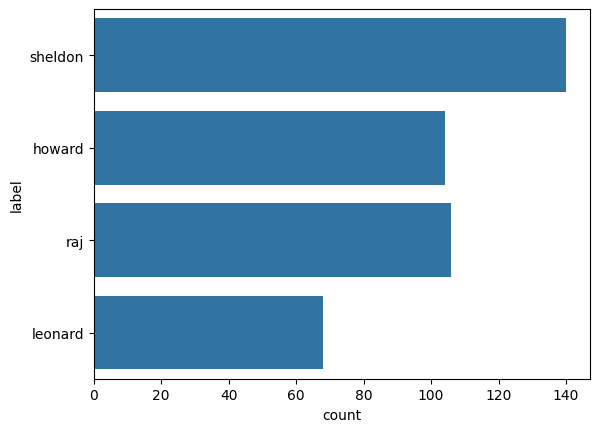

In [13]:
sns.countplot(train['label'])

In [14]:
# Converter para dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_images(test_dir)
# Embaralhar o datase
test = test.sample(frac=1).reset_index(drop=True)
test.head()

raj loaded
sheldon loaded
leonard loaded
howard loaded


,image,label
0,/content/drive/MyDrive/actors_bbt_split/test/s...,sheldon
1,/content/drive/MyDrive/actors_bbt_split/test/h...,howard
2,/content/drive/MyDrive/actors_bbt_split/test/s...,sheldon
3,/content/drive/MyDrive/actors_bbt_split/test/h...,howard
4,/content/drive/MyDrive/actors_bbt_split/test/r...,raj


<Axes: xlabel='count', ylabel='label'>

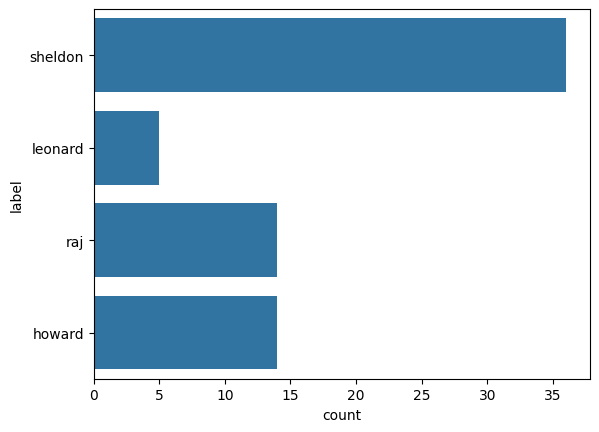

In [ ]:
sns.countplot(test['label'])

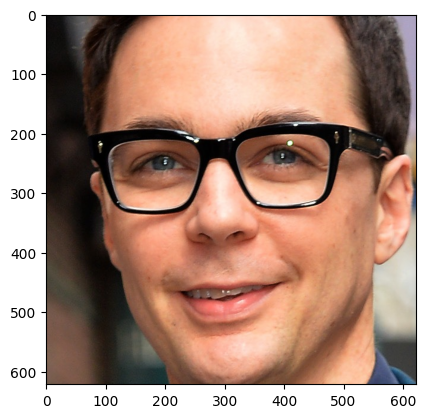

In [15]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img)

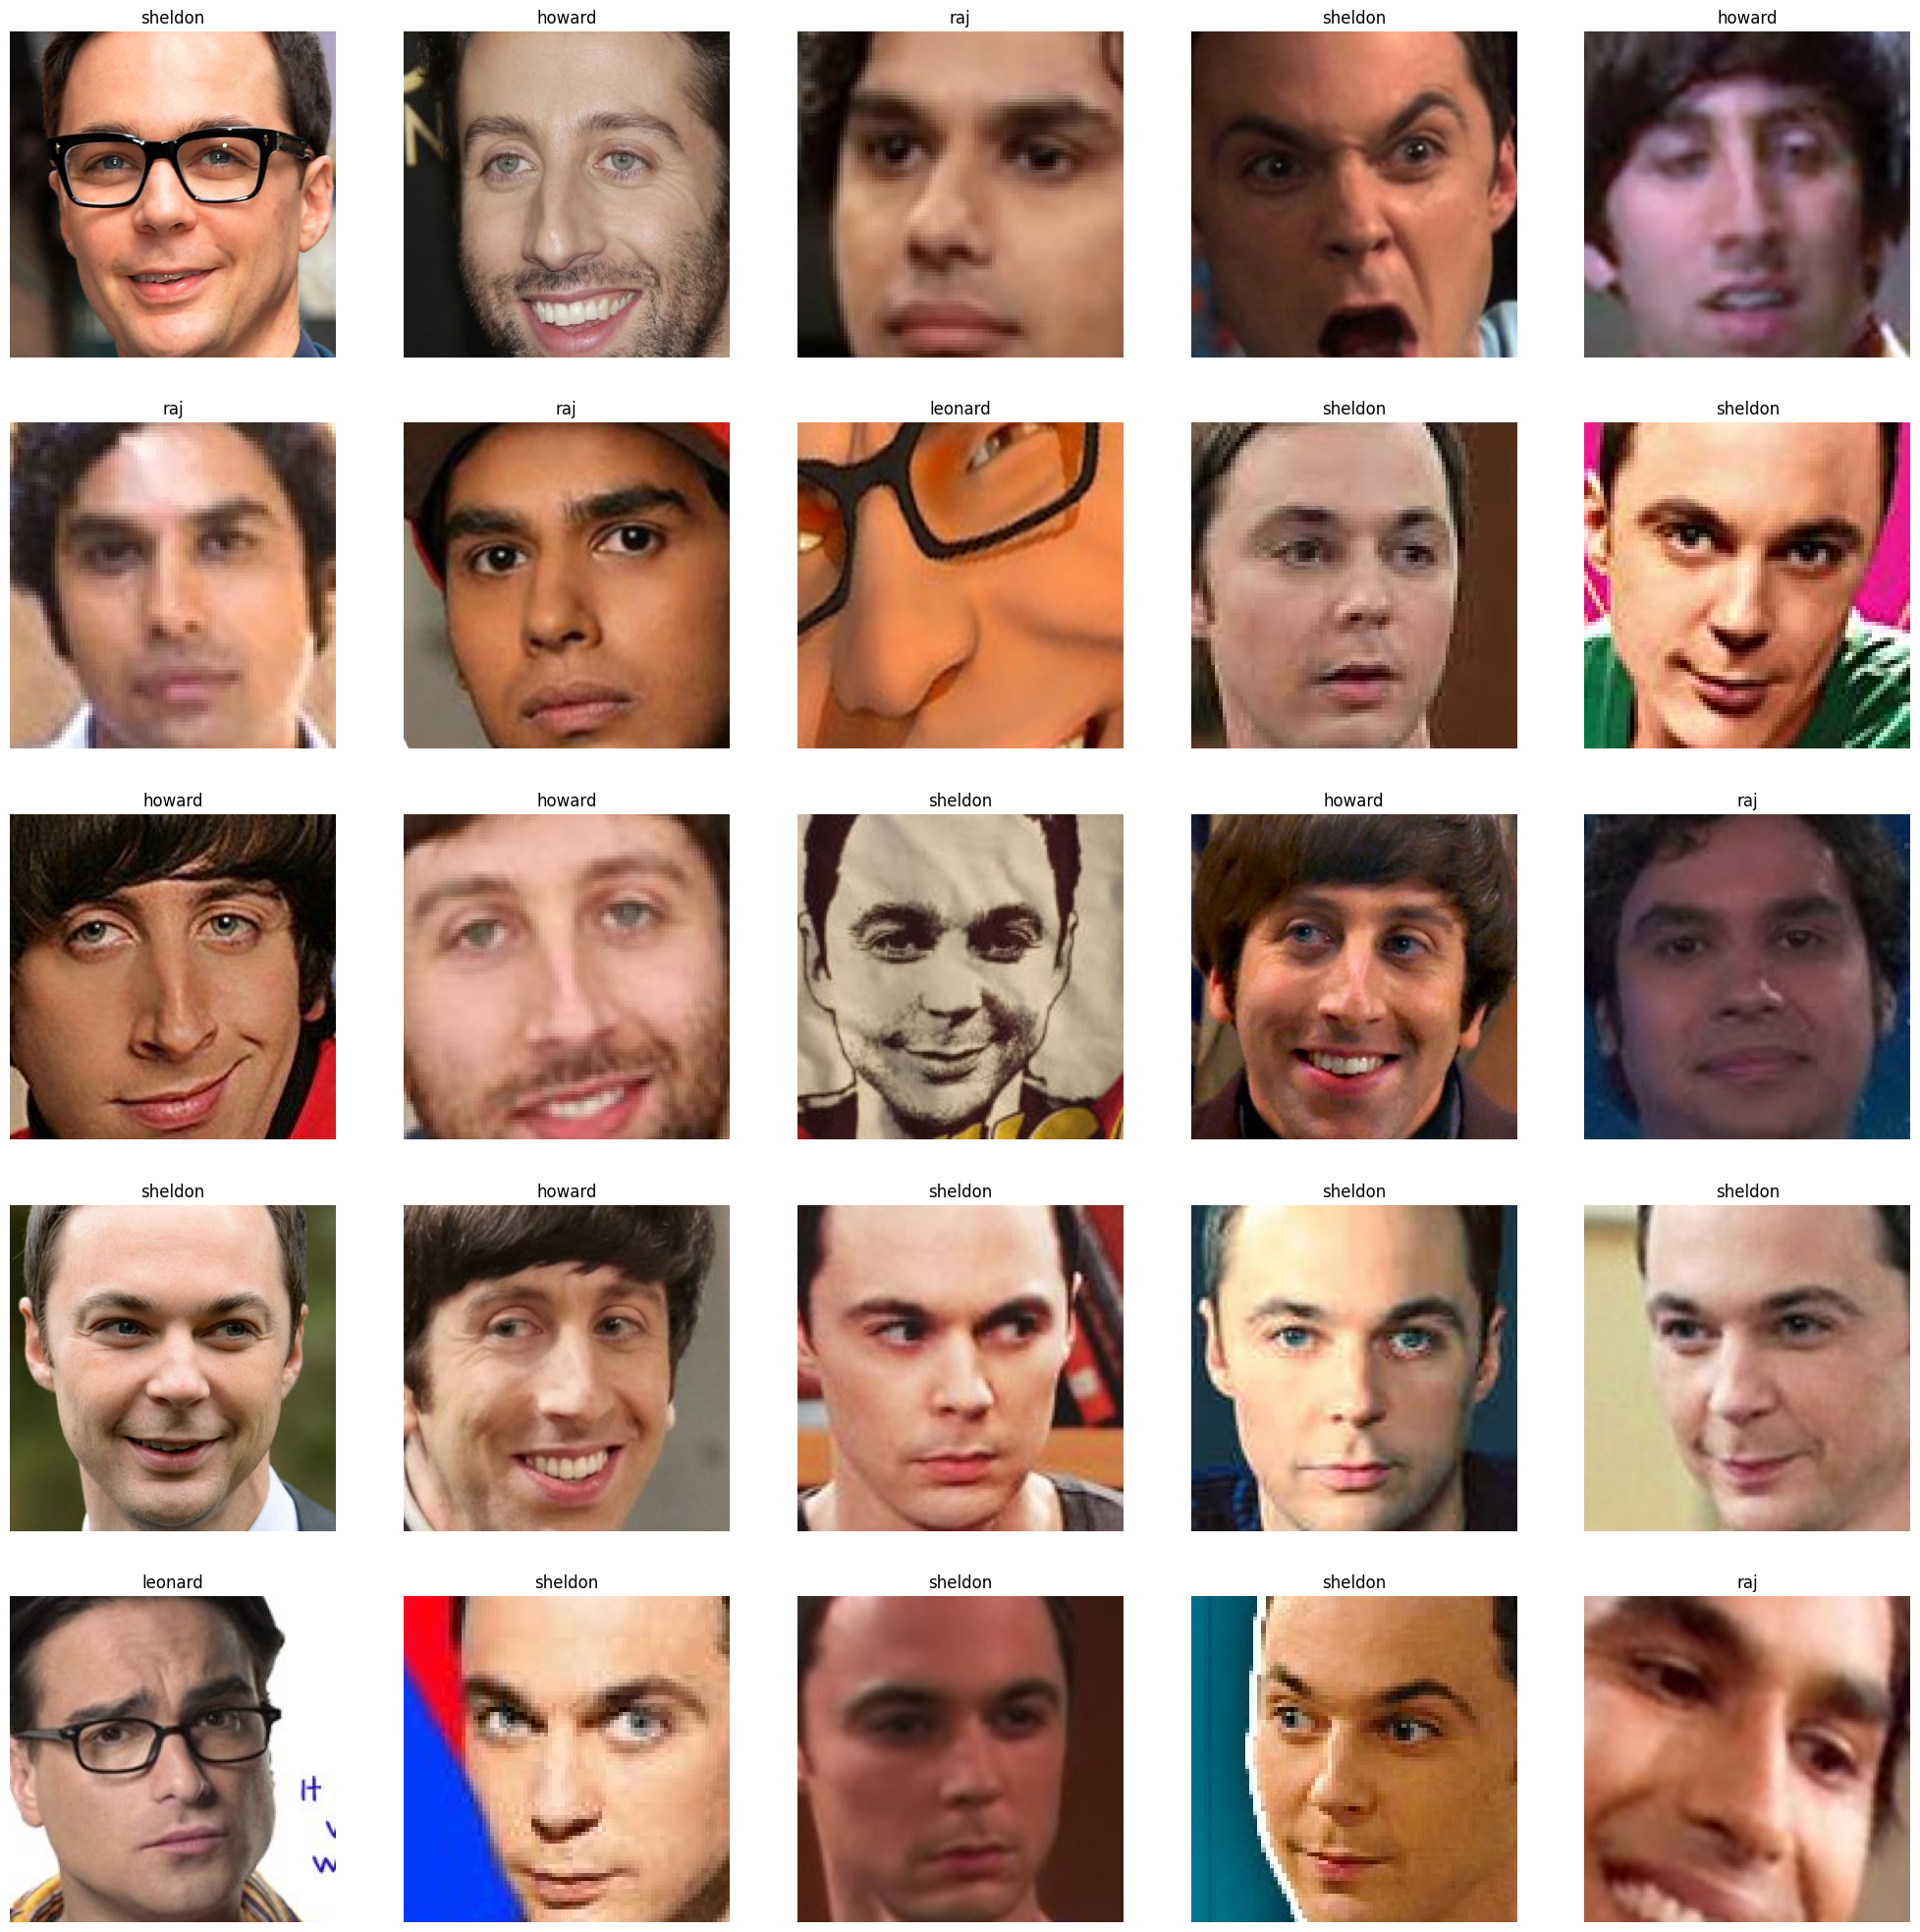

In [16]:
# Display as imagens do datase em grid
plt.figure(figsize=(25, 25))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Função de extração das imagens dos atores

A função extract_actors(images) tem como objetivo carregar imagens, convertê-las em um formato numérico adequado para aprendizado de máquina e, em seguida, armazená-las em um formato específico.

**Inicialização:**

def extract_actors(images): : Esta linha define uma função chamada extract_actors que recebe uma lista de caminhos de imagem (imagens) como entrada.
actors = []: Uma lista vazia chamada actors é criada para armazenar as imagens processadas.
Carregamento e processamento de imagens:

for image in tqdm(images):: Este loop itera por cada caminho de imagem na lista de imagens usando tqdm, que fornece uma barra de progresso.
img = cv2.imread(image): Esta linha provavelmente tenta ler a imagem usando OpenCV (cv2), mas é imediatamente substituída pela próxima linha.
img = Image.open(image): Esta linha abre a imagem usando a biblioteca PIL (Pillow).
img = np.array(img): A imagem é convertida em uma matriz NumPy, essencialmente transformando-a em uma matriz de valores de pixel.
actors.append(img): A representação da matriz NumPy da imagem é adicionada à lista de atores.
Remodelagem da matriz:

actors = np.array(actors): A lista de atores, agora contendo todas as matrizes de imagens, é convertida em uma matriz NumPy.
actors = actors.reshape(len(actors), 48, 48, 1): Esta é uma etapa crucial para o aprendizado profundo. Ele remodela a matriz de atores para ter dimensões adequadas para uma Rede Neural Convolucional (CNN).
len(actors): Representa o número de imagens.
48, 48: Especifica que cada imagem deve ser redimensionada para 48x48 pixels, um tamanho comum em reconhecimento de imagem.
1: Indica que as imagens são em tons de cinza (canal de cor única). Se as imagens fossem RGB, esse valor seria 3.
Retornando o resultado:

return actors: A função retorna o array actors final contendo os dados de imagem processados ​​e remodelados.
Em resumo: A função extract_actors pega uma lista de caminhos de imagem, carrega cada imagem, converte-os em arrays NumPy e os remodela em um formato adequado para uso em uma CNN, normalmente para tarefas de reconhecimento ou classificação de imagem.

In [17]:
def extract_actors(images):
  actors = []
  for image in tqdm(images):
    img = load_img(image, target_size=(48,48), color_mode='rgb')
    img = np.array(img)
    actors.append(img)

  actors = np.array(actors)

  return actors

In [18]:
train_actors = extract_actors(train['image'])

  0%|          | 0/418 [00:00<?, ?it/s]

In [20]:
test_actors = extract_actors(test['image'])

  0%|          | 0/69 [00:00<?, ?it/s]

## Normalização das imagens

In [21]:
x_train = train_actors/255.0
x_test = test_actors/255.0

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [23]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [24]:
print("Shape x_train:", x_train.shape)
print("Shape y_train:", y_train.shape)

print("Shape x_test:", x_test.shape)
print("Shape y_test:", y_test.shape)

Shape x_train: (418, 48, 48, 3)
Shape y_train: (418, 4)
Shape x_test: (69, 48, 48, 3)
Shape y_test: (69, 4)


## Calculo dos pesos

Como temos o número de imagens é desbalanceada precisamos calcular os pesos par que seja adicionado ao modelo de treinamento.

In [ ]:
# Converte one-hot para índices inteiros (ex: [0, 2, 1, 3])
y_train_indices = np.argmax(y_train, axis=1)  # Chave aqui!

# Calcula os pesos
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_indices),  # Classes únicas (ex: [0, 1, 2, 3])
    y=y_train_indices                    # Labels como inteiros
)
class_weights = dict(enumerate(class_weights))

In [26]:
!pip install Augmentor

## Aumento do número de imagens

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [ ]:
import Augmentor
from Augmentor import Pipeline

# Lista de diretórios das classes minoritárias (ajuste os nomes!)
minority_classes = ['leonard', 'howard', 'raj']

for class_name in minority_classes:
    # Caminho correto (assumindo que 'train' contém subpastas com os nomes das classes)
    pipeline = Augmentor.Pipeline(f"/content/drive/MyDrive/actors_bbt_split/train/{class_name}")

    # Operações de augmentation
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    # Gera 200 novas imagens (ajuste conforme necessidade)
    pipeline.sample(200)  # Não exagere no número!

Initialised with 18 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/leonard/output.

Processing <PIL.Image.Image image mode=RGB size=172x172 at 0x79555345CA10>: 100%|██████████| 200/200 [00:08<00:00, 23.05 Samples/s]


Initialised with 54 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/howard/output.

Processing <PIL.Image.Image image mode=RGB size=206x206 at 0x79554140B0D0>: 100%|██████████| 200/200 [00:09<00:00, 20.71 Samples/s]


Initialised with 56 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/raj/output.

Processing <PIL.Image.Image image mode=RGB size=294x294 at 0x795541343890>: 100%|██████████| 200/200 [00:09<00:00, 20.08 Samples/s]


In [27]:
!tree /content/drive/MyDrive/actors_bbt_split/ -d

/content/drive/MyDrive/actors_bbt_split/
├── test
│   ├── howard
│   ├── leonard
│   ├── raj
│   └── sheldon
└── train
    ├── howard
    ├── leonard
    ├── raj
    └── sheldon

10 directories


In [28]:
train_actors = extract_actors(train['image'])
x_train = train_actors / 255.0

  0%|          | 0/418 [00:00<?, ?it/s]

In [29]:
print("Número total de imagens de treino após augmentation:", len(train['image']))

Número total de imagens de treino após augmentation: 418


## Distribuição das imagens em cada diretório

In [36]:
import numpy as np
print("Contagem de amostras por classe:", np.bincount(y_train_indices))

Contagem de amostras por classe: [104  68 106 140]


## Rede aplicada para o treinamento da rede neural

In [38]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Treinamento do modelo

In [39]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Re-initialize the ImageDataGenerator to ensure it's in the current scope
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Treino
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2711 - loss: 1.4112

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.2712 - loss: 1.4105 - val_accuracy: 0.5217 - val_loss: 1.3429
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2820 - loss: 1.3968 - val_accuracy: 0.2029 - val_loss: 1.3752
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2788 - loss: 1.3927 - val_accuracy: 0.2029 - val_loss: 1.3984
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2505 - loss: 1.3653

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2515 - loss: 1.3660 - val_accuracy: 0.4348 - val_loss: 1.3333
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2090 - loss: 1.3878 - val_accuracy: 0.1159 - val_loss: 1.4025
Epoch 6/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3153 - loss: 1.3360

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3205 - loss: 1.3355 - val_accuracy: 0.5507 - val_loss: 1.1367
Epoch 7/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5350 - loss: 1.2035

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5333 - loss: 1.2038 - val_accuracy: 0.6377 - val_loss: 1.1347
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5215 - loss: 1.1310 - val_accuracy: 0.2174 - val_loss: 1.1802
Epoch 9/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4886 - loss: 1.1434

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4930 - loss: 1.1399 - val_accuracy: 0.6957 - val_loss: 0.8132
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5142 - loss: 1.1314 - val_accuracy: 0.5217 - val_loss: 0.8891
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6092 - loss: 0.9725 - val_accuracy: 0.4348 - val_loss: 1.1417
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5122 - loss: 1.1274 - val_accuracy: 0.4928 - val_loss: 1.0162
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5974 - loss: 0.9633 - val_accuracy: 0.4203 - val_loss: 1.2583
Epoch 14/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6337 - loss: 0.8795

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6351 - loss: 0.8775 - val_accuracy: 0.7101 - val_loss: 0.6803
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6555 - loss: 0.8646 - val_accuracy: 0.6087 - val_loss: 0.8727
Epoch 16/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6954 - loss: 0.7886 - val_accuracy: 0.7101 - val_loss: 0.8182
Epoch 17/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6746 - loss: 0.9137 - val_accuracy: 0.7101 - val_loss: 0.7024
Epoch 18/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7497 - loss: 0.7697

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7463 - loss: 0.7701 - val_accuracy: 0.7536 - val_loss: 0.6339
Epoch 19/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6922 - loss: 0.8244

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6922 - loss: 0.8250 - val_accuracy: 0.7536 - val_loss: 0.5998
Epoch 20/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7083 - loss: 0.7820

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7109 - loss: 0.7742 - val_accuracy: 0.7971 - val_loss: 0.5867
Epoch 21/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7859 - loss: 0.6538 - val_accuracy: 0.6232 - val_loss: 0.8634
Epoch 22/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7073 - loss: 0.7213

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7101 - loss: 0.7193 - val_accuracy: 0.7536 - val_loss: 0.5850
Epoch 23/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8099 - loss: 0.5759 - val_accuracy: 0.6812 - val_loss: 0.9087
Epoch 24/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8122 - loss: 0.5732

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8111 - loss: 0.5741 - val_accuracy: 0.8696 - val_loss: 0.4386
Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8287 - loss: 0.5505 - val_accuracy: 0.7391 - val_loss: 0.5476
Epoch 26/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7948 - loss: 0.5173 - val_accuracy: 0.7101 - val_loss: 0.6632
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7429 - loss: 0.5576 - val_accuracy: 0.8406 - val_loss: 0.4892
Epoch 28/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7104 - loss: 0.7292

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7123 - loss: 0.7262 - val_accuracy: 0.7826 - val_loss: 0.4361
Epoch 29/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8136 - loss: 0.5258 - val_accuracy: 0.8116 - val_loss: 0.5409
Epoch 30/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7421 - loss: 0.5516

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7444 - loss: 0.5494 - val_accuracy: 0.8551 - val_loss: 0.4328
Epoch 31/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7461 - loss: 0.5942 - val_accuracy: 0.7391 - val_loss: 0.5733
Epoch 32/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8288 - loss: 0.4789 - val_accuracy: 0.8261 - val_loss: 0.4398
Epoch 33/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8368 - loss: 0.4710

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8347 - loss: 0.4760 - val_accuracy: 0.8406 - val_loss: 0.3711
Epoch 34/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8305 - loss: 0.4711 - val_accuracy: 0.8261 - val_loss: 0.5077
Epoch 35/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8602 - loss: 0.4337 - val_accuracy: 0.7826 - val_loss: 0.5018
Epoch 36/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7708 - loss: 0.5203 - val_accuracy: 0.8406 - val_loss: 0.4480
Epoch 37/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8416 - loss: 0.5157

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8419 - loss: 0.5144 - val_accuracy: 0.8696 - val_loss: 0.3554
Epoch 38/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8325 - loss: 0.5164 - val_accuracy: 0.7971 - val_loss: 0.4484
Epoch 39/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8733 - loss: 0.4002

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8723 - loss: 0.4005 - val_accuracy: 0.8841 - val_loss: 0.3069
Epoch 40/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8516 - loss: 0.4383

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8513 - loss: 0.4385 - val_accuracy: 0.8986 - val_loss: 0.3011
Epoch 41/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8406 - loss: 0.4309 - val_accuracy: 0.8551 - val_loss: 0.3511
Epoch 42/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8802 - loss: 0.3598 - val_accuracy: 0.8696 - val_loss: 0.4588
Epoch 43/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8303 - loss: 0.4536 - val_accuracy: 0.7826 - val_loss: 0.5489
Epoch 44/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8577 - loss: 0.4236 - val_accuracy: 0.7826 - val_loss: 0.6070
Epoch 45/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8287 - loss: 0.4489

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8302 - loss: 0.4456 - val_accuracy: 0.9130 - val_loss: 0.2316
Epoch 46/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8473 - loss: 0.4792 - val_accuracy: 0.8551 - val_loss: 0.3319
Epoch 47/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8392 - loss: 0.4066 - val_accuracy: 0.8986 - val_loss: 0.2782
Epoch 48/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8887 - loss: 0.3940 - val_accuracy: 0.8551 - val_loss: 0.3937
Epoch 49/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8520 - loss: 0.3430 - val_accuracy: 0.8841 - val_loss: 0.3063
Epoch 50/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8407 - loss: 0.4106 - val_accuracy: 0.8406 - val_loss: 0.4060
Epoch 51/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9070 - loss: 0.2652 - val_accuracy: 0.8406 - val_loss: 0.4405
Epoch 52/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9058 - loss: 0.3190 - val_accuracy: 0.8841 

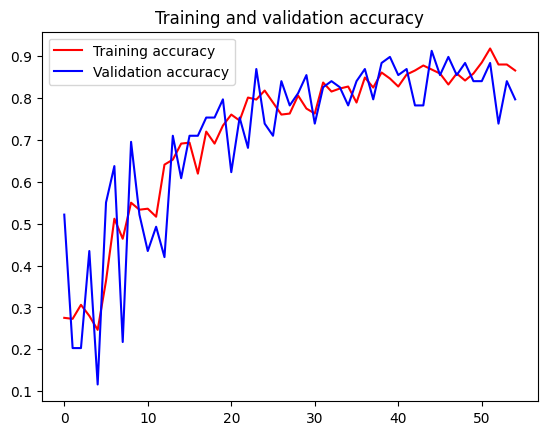

<Figure size 640x480 with 0 Axes>

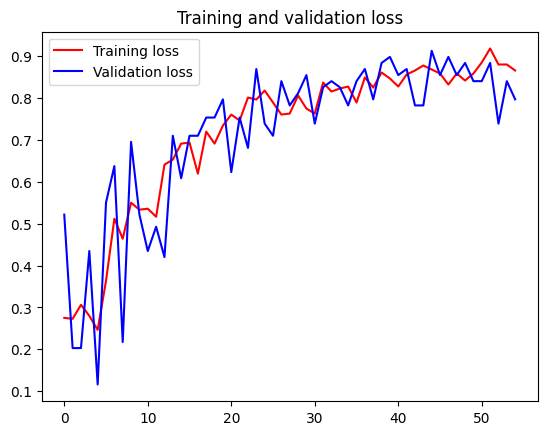

<Figure size 640x480 with 0 Axes>

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Original output sheldon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted output sheldon


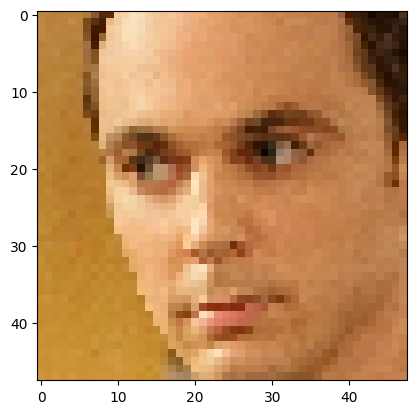

In [57]:
image_index = random.randint(0, len(test))
print("Original output", test['label'][image_index])
pred = model.predict(test_actors[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted output", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48, 3))

## Conclusão

Mesmo com um número reduzido de imagens e mesmo que aplicado o aumento de imagens o modelo foi bem treinado. A acurácia chegou a 0.9078. Depois de treinado o modelo foi aplicado em uma imagem aleatória e os resultados foram satisfatóros.